In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Umbralizado
Primero umbralizamos la imagen con un umbralizado básico y luego con otro adaptativo y luego obtenemos los contornos. De momento el normal da mejores resultados

In [6]:
# Umbralizado normal
imagen = cv2.imread("test_ocr_panels/00033_0.png", 0)
imagenUmbralizada = imagen.copy()
imagenUmbralizada[imagen>60] = 255
imagenUmbralizada[imagen<=60] = 0
contornos, _ = cv2.findContours(imagenUmbralizada, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
imagenContornos = np.zeros_like(imagen)
cv2.drawContours(imagenContornos, contornos, -1, (255, 255, 255), 1)
cv2.imshow("Imagen Umbralizada", imagenUmbralizada)
cv2.imshow("Imagen con Contornos", imagenContornos)
cv2.waitKey(0)
cv2.destroyAllWindows()
#plt.imshow(imagenContornos, cmap="gray")

In [5]:
# Umbralizado adaptativo - NO USAR POR EL MOMENTO
imagen = cv2.imread("test_ocr_panels/00006_0.png", 3)
# Comprobamos si hay niebla
hsv_image = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV) 
s_channel = hsv_image[:,:,1] 
indexSaturation = np.mean(s_channel) 
print(indexSaturation)
if (indexSaturation<20):
    hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    hsv[:,:,1] = np.clip(hsv[:,:,1] * 2.9, 0, 0)
    imagen = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    print("Saturamos")
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
imagenUmbralizada = cv2.adaptiveThreshold(imagen,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,3)
contornos, _ = cv2.findContours(imagenUmbralizada, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
imagenContornos = np.zeros_like(imagen) # Cargamos una imagen en negro donde vamos a dibujar los contornos
cv2.drawContours(imagenContornos, contornos, -1, (255, 255, 255), 1)
cv2.imshow("Imagen escala de grises", imagen)
cv2.imshow("Imagen Umbralizada", imagenUmbralizada)
cv2.imshow("Imagen con Contornos", imagenContornos)
cv2.waitKey(0)
cv2.destroyAllWindows()
#plt.imshow(imagenContornos, cmap="gray")

167.30292981061748


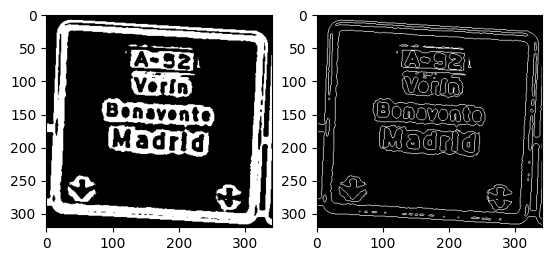

In [71]:
imagen = cv2.imread("test_ocr_panels/00006_0.png", 3)
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(imagen, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                               cv2.THRESH_BINARY_INV, 21, 4)
contornos, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
imagen_negra = np.zeros_like(imagen)
imagen_contornos_blancos = cv2.drawContours(imagen_negra, contornos, -1, (255), 1)
plt.subplot(1, 2, 1)
plt.imshow(thresh, 'gray')
plt.subplot(1,2,2)
plt.imshow(imagen_contornos_blancos, 'gray')

## MSER
Acto seguido tendremos que detectar los caracteres del panel usando MSER

In [74]:
# MSER
def mser(imagenUmbralizada, imagen):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    imagenUmbralizada = cv2.dilate(imagenUmbralizada, kernel)
    mser = cv2.MSER_create(delta=5, max_variation=0.8, min_area=50, max_area=500)
    polygons, _ = mser.detectRegions(imagenUmbralizada)
    copy = imagen.copy()
    rectangles = []
    for p in polygons:
        x, y, w, h = cv2.boundingRect(p)
        if (h / w > 1.0 and h / w <= 1.9) or (h / w > 2 and h / w <= 3.5):
            cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 1)
            rectangles.append((x,y,w,h))
    cv2.imshow("Regiones detectadas por MSER", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return rectangles

imagen = cv2.imread("test_ocr_panels/00006_0.png")
rectanglesDetected = mser(imagen_contornos_blancos, imagen)

## Agrupación de los centros
Una vez tenemos los rectángulos de cada caracter, tendremos que calcular sus centros para luego pasarselo al RANSAC. Antes tendremos que agrupar estos centros en conjuntos de palabras en función de su proximidad con cada uno de los puntos en el eje X

In [75]:
# Calculamos los centros de cada cuadro detectado
def calcularCentros(rectanglesDetected):
    centros = []
    for rectangle in rectanglesDetected:
        x, y, w, h = rectangle
        center = (x + (w//2), y + (h//2))
        centros.append(list(center))
    return centros

def dibujarCentros(centros, imagen):
    copy = imagen.copy()
    for center in centros:
        cv2.circle(copy, (center[0], center[1]), radius=1, color=(0, 0, 255), thickness=2)
    cv2.imshow("Centros detectados", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

centros = calcularCentros(rectanglesDetected)
dibujarCentros(centros, imagen)

In [105]:
print(len(centros))
print(len(rectanglesDetected))

26
26


In [199]:
# DEPRECATED
"""
import math
import numpy as np

# Eliminamos los cuadrados donde sus centros están muy próximos, evitamos así posibles duplcidades
def eliminarCentrosDuplicados(centros, rectagles):
    puntosFiltrados = []
    rectanglesFiltrados = []
    puntosMarcados = set()
    distancias = [] # Array que contiene las distancias con cada uno de los puntos
    for i in range(len(centros)):
        distancias = []
        if i not in puntosMarcados: # Comprobamos si ese punto ya ha sido explorado
            puntoActual = centros[i]
            rectanguloActual = rectagles[i]
            puntosFiltrados.append(puntoActual)
            rectanglesFiltrados.append(rectanguloActual)
            for j in range(i+1, len(centros)):
                rectangle1 = rectagles[i]
                rectangle2 = rectagles[j]
                centro1 = centros[i]
                centro2 = centros[j]
                x = abs(centro1[0] - centro2[0])
                y = abs(centro1[1] - centro2[1])
                distancia = math.sqrt(x**2 + y**2)
                if (distancia < 8):
                    _, _, h1, w1 = rectangle1[i]
                    _, _, h2, w2 = rectangle2[j]
                    
                    puntosMarcados.add(j)
                distancias.append(distancia)
            media = np.mean(np.array(distancias))
            if (media >= 180):
                print('Eliminamos también al ser un punto desviado ',centro1)
                puntosFiltrados.remove(centro1)
                rectanglesFiltrados.remove(rectangle1)
    return puntosFiltrados, rectanglesFiltrados

def dibujarRectangulos(rectangulos, imagen):
    copy = imagen.copy()
    for rectangle in rectangulos:
        x, y, w, h = rectangle
        cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 1)
    cv2.imshow("Centros detectados", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

centrosNuevos, rectanglesNuevos = eliminarCentrosDuplicados(centros, rectanglesDetected)
dibujarCentros(centrosNuevos, imagen)
dibujarRectangulos(rectanglesNuevos, imagen)
"""

'\nimport math\nimport numpy as np\n\n# Eliminamos los cuadrados donde sus centros están muy próximos, evitamos así posibles duplcidades\ndef eliminarCentrosDuplicados(centros, rectagles):\n    puntosFiltrados = []\n    rectanglesFiltrados = []\n    puntosMarcados = set()\n    distancias = [] # Array que contiene las distancias con cada uno de los puntos\n    for i in range(len(centros)):\n        distancias = []\n        if i not in puntosMarcados: # Comprobamos si ese punto ya ha sido explorado\n            puntoActual = centros[i]\n            rectanguloActual = rectagles[i]\n            puntosFiltrados.append(puntoActual)\n            rectanglesFiltrados.append(rectanguloActual)\n            for j in range(i+1, len(centros)):\n                rectangle1 = rectagles[i]\n                rectangle2 = rectagles[j]\n                centro1 = centros[i]\n                centro2 = centros[j]\n                x = abs(centro1[0] - centro2[0])\n                y = abs(centro1[1] - centro2[1]

In [76]:

def intersectionOverUnion(box1, box2):
    # Obtenemos los puntos x1, y1 y x2, y2 de la región primera
    xA1, yA1, wA, hA = box1
    xA2 = xA1 + wA
    yA2 = yA1 + hA
    # Obtenemos los puntos x1, y1 y x2, y2 de la región segunda
    xB1, yB1, wB, hB = box2
    xB2 = xB1 + wB
    yB2 = yB1 + hB
    # Coordenadas de la intersección
    xI1 = max(xA1, xB1)
    yI1 = max(yA1, yB1)
    xI2 = min(xA2, xB2)
    yI2 = min(yA2, yB2)
    # Área de la intersección
    interWidth = max(0, xI2 - xI1)
    interHeight = max(0, yI2 - yI1)
    interArea = interWidth * interHeight
    box1Area = wA * hA
    box2Area = wB * hB
    unionArea = box1Area + box2Area - interArea
    iou = interArea / unionArea
    return iou

def eliminarRectangulosDuplicados(rectangulos, centros):
    eliminarIndices = set()
    for i in range(len(rectangulos)):
        for j in range(i+1, len(rectangulos)):
            x1, y1, w1, h1 = rectangulos[i]
            x2, y2, w2, h2 = rectangulos[j]
            area1 = w1 * h1
            area2 = w2 * h2
            # Comprobamos viendo los puntos si están contenidos
            #if (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2):
            iouValue = abs(intersectionOverUnion(rectangulos[i], rectangulos[j]))
            if (iouValue > 0.1):
                if (area1 >= area2):
                    eliminarIndices.add(j)
                else:
                    eliminarIndices.add(i)
    rectangulosFiltrados = []
    centrosFiltrados = []
    for i in range(len(rectangulos)):
        if i not in eliminarIndices:
            rectangulosFiltrados.append(rectangulos[i])
            centrosFiltrados.append(centros[i])
    return rectangulosFiltrados, centrosFiltrados

def dibujarRectangulos(rectangulos, imagen):
    copy = imagen.copy()
    for rectangle in rectangulos:
        x, y, w, h = rectangle
        cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 1)
    cv2.imshow("Centros detectados", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

nuevosRectangulos, centrosNuevos = eliminarRectangulosDuplicados(rectanglesDetected, centros)
dibujarRectangulos(nuevosRectangulos, imagen)

In [25]:
from sklearn.linear_model import RANSACRegressor
import random

# Agrupamos cada caracter con su conjunto de palabras de la linea
def agruparCentros(points, min_samples=2, residual_threshold=10):
    lines = []
    remaining_points = points.copy()
    
    while len(remaining_points) >= min_samples:
        X = np.array([p[0] for p in remaining_points]).reshape(-1, 1)
        Y = np.array([p[1] for p in remaining_points])
        
        ransac = RANSACRegressor(min_samples=min_samples, residual_threshold=residual_threshold)
        ransac.fit(X, Y)
        
        inliers_mask = ransac.inlier_mask_
        outliers_mask = np.logical_not(inliers_mask)
        
        # Store the inliers as a line
        inliers = [remaining_points[i] for i in range(len(remaining_points)) if inliers_mask[i]]
        lines.append(inliers)
        
        # Update remaining points to outliers only
        remaining_points = [remaining_points[i] for i in range(len(remaining_points)) if outliers_mask[i]]
    
    return lines

def dibujarLineas(lineas, centros, imagen):
    copy = imagen.copy()
    for i, linea in enumerate(lineas):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        for point in linea:
            cv2.circle(copy, point, radius=1, color=color, thickness=5)
    cv2.imshow("Centros detectados", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

puntosAgrupados = agruparCentros(centrosNuevos)
dibujarLineas(puntosAgrupados, centrosNuevos, imagen)

In [28]:
from sklearn.linear_model import RANSACRegressor

def obtenerLineas(puntosAgrupados, imagen):
    alto, ancho, _ = imagen.shape
    lines = []
    ransac = RANSACRegressor()
    for puntos in puntosAgrupados:
        centrosX = [sublista[0] for sublista in puntos]
        centrosY = [sublista[1] for sublista in puntos]
        centrosX = np.array(centrosX).reshape(-1, 1)
        centrosY = np.array(centrosY)

        ransac.fit(centrosX, centrosY)
        x0 = centrosX.min()
        x1 = centrosX.max()  # Usamos el rango de nuestros datos
        y0 = ransac.estimator_.intercept_
        y1 = x1 * ransac.estimator_.coef_[0] + ransac.estimator_.intercept_
        start_point = (0, int(y0))
        end_point = (ancho-1, int(y1))
        lines.append([start_point, end_point])
    return lines

def dibujarLineas(lineas, puntosAgrupados, imagen):
    copy = imagen.copy()
    for i, line in enumerate(lineas):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        start_point = line[0]
        end_point = line[1]
        cv2.line(copy, start_point, end_point, color=color, thickness=1)
        for punto in puntosAgrupados[i]:
            cv2.circle(copy, punto, radius=1, color=color, thickness=5)
    cv2.imshow("Lineas detectadas", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

lines = obtenerLineas(puntosAgrupados, imagen)
dibujarLineas(lines, puntosAgrupados, imagen)

In [27]:
def dibujarLineasRectangulos(lineas, rectangulos, imagen):
    copy = imagen.copy()
    for i, line in enumerate(lineas):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        start_point = line[0]
        end_point = line[1]
        cv2.line(copy, start_point, end_point, color=color, thickness=3)
        for rectangle in rectangulos:
            x, y, w, h = rectangle
            cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), 1)
    cv2.imshow("Lineas detectadas", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

dibujarLineasRectangulos(lines, nuevosRectangulos, imagen)

# ¡¡ DEPRECATED !!
# |
# v

In [190]:
import math
import numpy as np

# DEPRECATED
def eliminarCentrosDuplicados(centros):
    nuevosCentros = []
    distancias = []
    copiaCentros = centros.copy()
    for i,_ in enumerate(copiaCentros):
        for j,_ in enumerate(copiaCentros):
            centro1 = centros[i]
            centro2 = centros[j]
            x = abs(centro1[0] - centro2[0])
            y = abs(centro1[1] - centro2[1])
            distancia = math.sqrt(x**2 + y**2)
            if (distancia != 0): # No es él mismo
                if (distancia > 0 and distancia < 5):
                    copiaCentros.remove(centro1)
                    print('Eliminamos ',centro1)
            distancias.append(distancia)
        media = np.mean(np.array(distancias))
        if (media >= 150):
            copiaCentros.remove(centro1)
            print('Eliminamos también al ser un punto desviado ',centro1)
    return copiaCentros

def eliminar(centros):
    puntosFiltrados = []
    puntosMarcados = set()
    distancias = [] # Array que contiene las distancias con cada uno de los puntos
    for i in range(len(centros)):
        distancias = []
        if i not in puntosMarcados: # Comprobamos si ese punto ya ha sido explorado
            puntoActual = centros[i]
            puntosFiltrados.append(puntoActual)
            for j in range(i+1, len(centros)):
                centro1 = centros[i]
                centro2 = centros[j]
                x = abs(centro1[0] - centro2[0])
                y = abs(centro1[1] - centro2[1])
                distancia = math.sqrt(x**2 + y**2)
                if (distancia < 5):
                    puntosMarcados.add(j)
                distancias.append(distancia)
            media = np.mean(np.array(distancias))
            if (media >= 150):
                print('Eliminamos también al ser un punto desviado ',centro1)
                puntosFiltrados.remove(centro1)
    return puntosFiltrados

centros = eliminar(centros)
dibujarCentros(centros, imagen)

Eliminamos también al ser un punto desviado  [34, 106]


In [192]:
from sklearn import linear_model
from sklearn.cluster import DBSCAN
import random

def agruparCentros(centros, imagen):
    copy = imagen.copy()
    # Utilizamos DBSCAN para agrupar los centros en grupos
    dbscan = DBSCAN(eps=35, min_samples=1)
    y_pred = dbscan.fit_predict(centros)
    # Construimos los conjuntos a partir de las etiquetas obtenidas
    setCenters = []
    for _ in range(len(np.unique(y_pred))):
        setCenters.append([])
    for i, center in enumerate(centros):
        index = y_pred[i]
        if (len(setCenters[index]) == 0):
            setCenters[index] = [center]
        else:
            elem = setCenters[index]
            elem.append(center)
            setCenters[index] = elem
    print(len(setCenters))
    # Aplicamos RANSAC para cada uno de los conjuntos
    ransac = linear_model.RANSACRegressor()
    for set in setCenters:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255),)
        for center in set:
            cv2.circle(copy, (center[0], center[1]), radius=1, color=color, thickness=2)
        if (len(set) > 1):
            centrosX = [sublista[0] for sublista in set]
            centrosY = [sublista[1] for sublista in set]
            centrosX = np.array(centrosX).reshape(-1, 1)
            centrosY = np.array(centrosY)

            ransac.fit(centrosX, centrosY)
            x0 = centrosX.min()
            x1 = centrosX.max()  # Usamos el rango de nuestros datos
            y0 = ransac.estimator_.intercept_
            y1 = x1 * ransac.estimator_.coef_[0] + ransac.estimator_.intercept_
            start_point = (int(x0), int(y0))
            end_point = (int(x1), int(y1))
            cv2.line(copy, start_point, end_point, color=(0, 255, 0), thickness=1)
    cv2.imshow("Regiones detectadas por MSER", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

agruparCentros(centros, imagen)

3


In [105]:
import random

def agruparCentros(centros):
    centrosAgrupados = []
    puntosMarcados = set()
    for i in range(len(centros)):
        if i not in puntosMarcados:
            agrupadosActual = [centros[i]]
            centroActual = centros[i]
            puntosMarcados.add(i)
            for j in range(i + 1, len(centros)):
                centroSiguiente = centros[j]
                x = abs(centroActual[0] - centroSiguiente[0])
                y = abs(centroActual[1] - centroSiguiente[1])
                distancia = math.sqrt(x**2 + y**2)
                if j not in puntosMarcados and distancia < 30:
                    agrupadosActual.append(centros[j])
                    puntosMarcados.add(j)
                    centroActual = centroSiguiente
            centrosAgrupados.append(agrupadosActual)
    return centrosAgrupados

def dibujarCentrosAgrupados(centrosAgrupados, imagen):
    copia = imagen.copy()
    for i,centros in enumerate(centrosAgrupados):
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255),)
        for centro in centros:
            cv2.circle(copia, (centro[0], centro[1]), radius=1, color=color, thickness=2)
    cv2.imshow("Centros agrupados", copia)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

            
centrosAgrupados = agruparCentros(nuevosCentros)
dibujarCentrosAgrupados(centrosAgrupados, imagen)
len(centrosAgrupados)

8

In [84]:
import math

# Lista de puntos
centros = [
    [8, 173], [229, 197], [171, 193], [241, 155], [229, 195],
    [209, 153], [206, 112], [194, 195], [191, 153], [178, 111],
    [174, 151], [171, 192], [144, 66], [161, 110], [143, 107],
    [158, 151], [145, 192], [139, 149], [120, 148], [115, 187],
    [101, 144]
]

# Definir el umbral de distancia
umbral = 70  # ajusta este valor según tus necesidades

# Función para calcular la distancia euclidiana entre dos puntos
def distancia(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

# Lista para almacenar los clústeres de puntos
clusters = []

# Lista para almacenar los puntos que ya han sido agrupados
puntos_marcados = set()

for i in range(len(centros)):
    if i not in puntos_marcados:
        cluster_actual = [centros[i]]
        puntos_marcados.add(i)
        for j in range(i + 1, len(centros)):
            if j not in puntos_marcados and distancia(centros[i], centros[j]) < umbral:
                cluster_actual.append(centros[j])
                puntos_marcados.add(j)
        clusters.append(cluster_actual)

print("Clústeres de puntos:")
for cluster in clusters:
    print(cluster)
print(len(clusters))


Clústeres de puntos:
[[8, 173]]
[[229, 197], [171, 193], [241, 155], [229, 195], [209, 153], [194, 195], [191, 153], [171, 192]]
[[206, 112], [178, 111], [174, 151], [161, 110], [143, 107], [158, 151]]
[[144, 66]]
[[145, 192], [139, 149], [120, 148], [115, 187], [101, 144]]
5


In [5]:
from sklearn.linear_model import RANSACRegressor

def ransac(rectanglesDetected, imagen):
    ransac = RANSACRegressor()
    copy = imagen.copy()
    centrosX = []
    centrosY = []
    for rectangle in rectanglesDetected:
        x, y, w, h = rectangle
        center = (x + (w//2), y + (h//2))
        cv2.circle(copy, (center[0], center[1]), radius=1, color=(255, 255, 255), thickness=2)
        centrosX.append(center[0])
        centrosY.append(center[1])
    centrosX = np.array(centrosX).reshape(-1, 1)
    centrosY = np.array(centrosY)

    ransac.fit(centrosX, centrosY)
    x0 = centrosX.min()
    x1 = centrosX.max()  # Usamos el rango de nuestros datos
    y0 = ransac.estimator_.intercept_
    y1 = x1 * ransac.estimator_.coef_[0] + ransac.estimator_.intercept_
    start_point = (int(x0), int(y0))
    end_point = (int(x1), int(y1))

    # Dibujar la línea en la imagen
    #cv2.line(copy, start_point, end_point, color=(0, 0, 255), thickness=2)

    
    cv2.imshow("Regiones detectadas por MSER", copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

ransac(rectanglesDetected, imagen)